In [1]:
import pickle
import random

import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import conditional_monotonicity_check, get_preds_per_exit, get_acc_per_exit, anytime_product

In [2]:
# with open('../output/logits/cifar10.pkl', 'rb') as f:
# with open('../output/logits/cifar10_2.pkl', 'rb') as f:
with open('../output/logits/cifar10_LARGE.pkl', 'rb') as f:
    data = pickle.load(f)

logits, targets = data

B = max([len(x) for x in logits])
print(B)
for i in range(len(logits)):
    while len(logits[i]) < B:
        logits[i].append(logits[i][-1])

logits = torch.cat([torch.stack(tensors) for tensors in logits], dim=1)
# logits = np.concatenate([np.stack(tensors) for tensors in logits], axis=1)

targets = torch.cat(targets, dim=0)

15


In [3]:
logits.shape, targets.shape

(torch.Size([15, 10000, 10]), torch.Size([10000]))

In [4]:
# probs = torch.softmax(logits, dim=2)
probs = torch.softmax(logits[1:, :, :], dim=2)
preds = get_preds_per_exit(probs)
acc = get_acc_per_exit(preds, targets)

In [28]:
L, N, C = logits.shape

# need to shift logits to obtain (somewhat) comparable results
probs_pa = anytime_product(logits[1:, :, :] + 10., weights=(torch.arange(1, L, 1, dtype=float) / (L - 1)))
preds_pa = get_preds_per_exit(probs_pa)
acc_pa = get_acc_per_exit(preds_pa, targets)

In [29]:
acc

[tensor(0.3043),
 tensor(0.6141),
 tensor(0.8146),
 tensor(0.8582),
 tensor(0.8814),
 tensor(0.8896),
 tensor(0.8887),
 tensor(0.8894),
 tensor(0.8896),
 tensor(0.8898),
 tensor(0.8900),
 tensor(0.8897),
 tensor(0.8899),
 tensor(0.8899)]

In [30]:
acc_pa

[tensor(0.3043),
 tensor(0.5137),
 tensor(0.7193),
 tensor(0.7947),
 tensor(0.8327),
 tensor(0.8500),
 tensor(0.8570),
 tensor(0.8603),
 tensor(0.8628),
 tensor(0.8635),
 tensor(0.8635),
 tensor(0.8641),
 tensor(0.8648),
 tensor(0.8653)]

In [31]:
conditional_monotonicity_check(targets, probs)

{0.01: 49.830000000000005,
 0.05: 35.870000000000005,
 0.1: 28.560000000000002,
 0.2: 19.57,
 0.5: 7.5}

In [32]:
conditional_monotonicity_check(targets, probs_pa)

{0.01: 6.909999999999999, 0.05: 4.6, 0.1: 2.68, 0.2: 0.21, 0.5: 0.0}

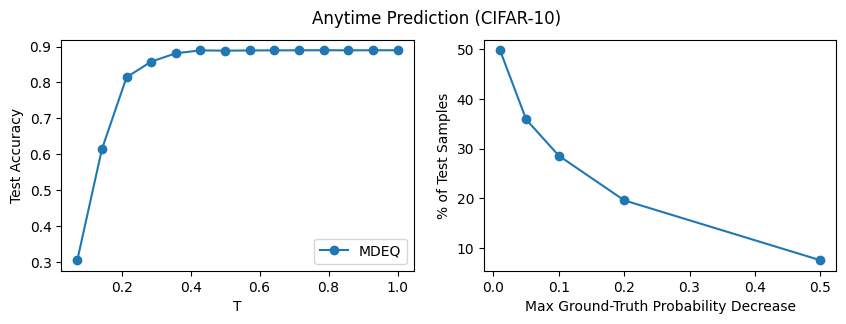

In [33]:
early_exits = [(i + 1) / len(acc) for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(early_exits, torch.stack(acc, dim=0).cpu().numpy(), label='MDEQ', marker='o',)
ax[0].legend()
ax[0].set_ylabel('Test Accuracy')
ax[0].set_xlabel('T')

modal_probs = conditional_monotonicity_check(targets, probs)
ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label='MDEQ')

ax[1].set_xlabel('Max Ground-Truth Probability Decrease')
ax[1].set_ylabel('% of Test Samples')


plt.suptitle(f'Anytime Prediction (CIFAR-10)')
plt.show()

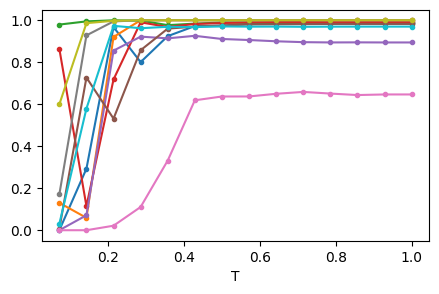

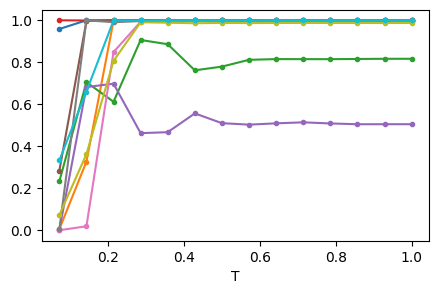

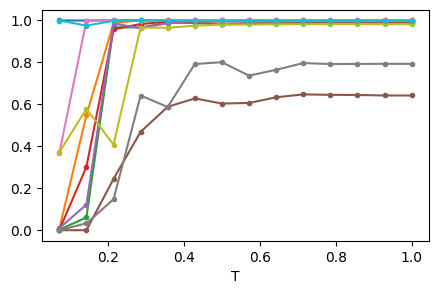

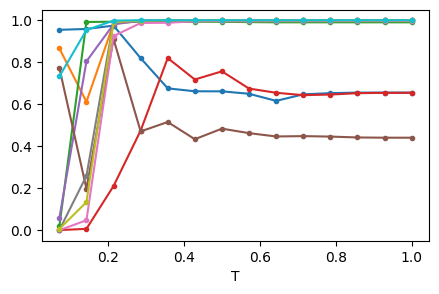

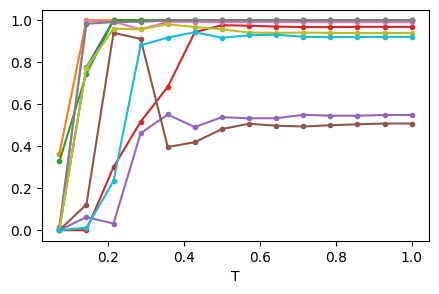

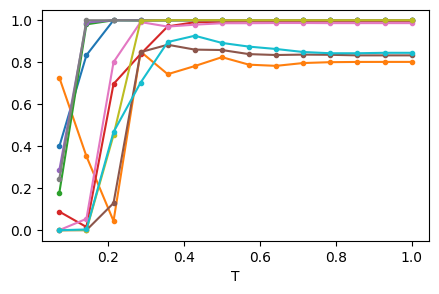

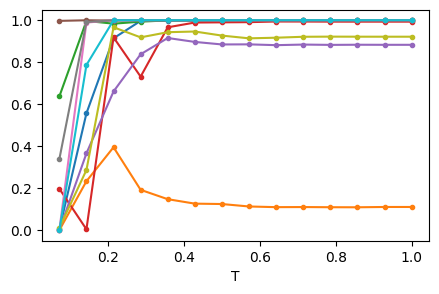

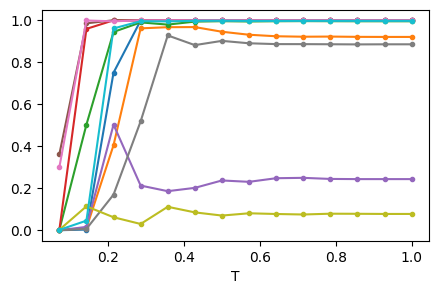

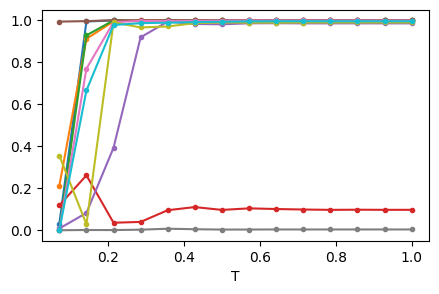

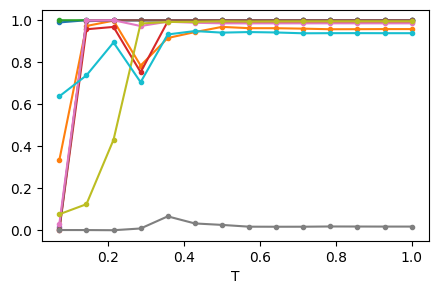

In [35]:
random.seed(0)

for _ in range(10):
    samples = random.sample(range(10000), 10)
    # set figure size
    plt.figure(figsize=(5, 3))
    for i in samples:
        # probs_i = probs_pa[:, i, targets[i]].cpu()
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot([x / len(probs_i) for x in list(range(1, len(probs_i) + 1))], probs_i, label=f'{i}', marker='o', ms=3);
    plt.xlabel('T')
    plt.show()